In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import explore as e

import os
from env import host, user, password

## Acquire

In [3]:
# The following functions will be used to acquire all the data from the SQL database 'telco_churn'
# These functions will also be stored in the acquire.py file

def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def new_telco_data():
    '''
    This function reads the telco data from the Codeup db into a df,
    writes it to a csv file, and returns the df.
    '''

    # Create SQL query.
    sql_query = """
           SELECT c.customer_id,
                c.gender, 
                c.senior_citizen,
                c.partner,
                c.dependents,
                c.tenure,
                c.phone_service,
                c.multiple_lines,
                c.online_security,
                c.device_protection,
                c.tech_support,
                c.streaming_tv,
                c.streaming_movies,
                c.paperless_billing,
                c.monthly_charges,
                c.total_charges,
                c.churn,
                ct.contract_type,
                i.internet_service_type,
                p.payment_type
FROM customers as c
JOIN contract_types as ct USING (contract_type_id)
JOIN internet_service_types as i USING (internet_service_type_id)
JOIN payment_types as p USING (payment_type_id);
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('telco_churn'))
    
    return df

def get_telco_data():
    '''
    This function reads in telco data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('telco_df.csv'):
        
        # If csv file exists, read in data from csv file.
        df = pd.read_csv('telco_df.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame.
        df = new_telco_data()
        
        # Write DataFrame to a csv file.
        df.to_csv('telco_df.csv')
        
    return df

df = get_telco_data()
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,0017-DINOC,Male,0,No,No,54,No,No phone service,Yes,No,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,Yes,Yes,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,Yes,Yes,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


## Prepare

Summarize:

In [8]:
df.shape

(7043, 20)

In [10]:
df.drop_duplicates(inplace=True)
df.shape

(7043, 20)

In [11]:
df.describe()

,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [12]:
df.isnull().sum()

customer_id              0
gender                   0
senior_citizen           0
partner                  0
dependents               0
tenure                   0
phone_service            0
multiple_lines           0
online_security          0
device_protection        0
tech_support             0
streaming_tv             0
streaming_movies         0
paperless_billing        0
monthly_charges          0
total_charges            0
churn                    0
contract_type            0
internet_service_type    0
payment_type             0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7043 non-null   object 
 1   gender                 7043 non-null   object 
 2   senior_citizen         7043 non-null   int64  
 3   partner                7043 non-null   object 
 4   dependents             7043 non-null   object 
 5   tenure                 7043 non-null   int64  
 6   phone_service          7043 non-null   object 
 7   multiple_lines         7043 non-null   object 
 8   online_security        7043 non-null   object 
 9   device_protection      7043 non-null   object 
 10  tech_support           7043 non-null   object 
 11  streaming_tv           7043 non-null   object 
 12  streaming_movies       7043 non-null   object 
 13  paperless_billing      7043 non-null   object 
 14  monthly_charges        7043 non-null   float64
 15  tota

In [15]:
# total_charges replace non-numeric values with str '0' and cast to float dtype
df.total_charges = df.total_charges.str.replace(' ','0.00').astype(float)

AttributeError: Can only use .str accessor with string values!

In [ ]:
# convert ['Yes','No'] outcomes to binary
df = df.replace({'paperless_billing': {'Yes': 1, 'No': 0}})
df = df.replace({'partner': {'Yes': 1, 'No': 0}})
df = df.replace({'dependents': {'Yes': 1, 'No': 0}})
df = df.replace({'phone_service': {'Yes': 1, 'No': 0}})
df = df.replace({'churn': {'Yes': 1, 'No': 0}})
df = df.replace({'churn': {'Yes': 1, 'No': 0}})

In [17]:
cat_vars = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type']

In [18]:
for x in cat_vars:
    counts = df[x].value_counts()
    counts_per = df[x].value_counts(normalize=True, dropna=False)
    print(x.capitalize())
    print(f'{counts}')
    print(f'{round(counts_per, 4)}\n')
    print(f'-------\n')

Gender
Male      3555
Female    3488
Name: gender, dtype: int64
Male      0.5048
Female    0.4952
Name: gender, dtype: float64

-------

Senior_citizen
0    5901
1    1142
Name: senior_citizen, dtype: int64
0    0.8379
1    0.1621
Name: senior_citizen, dtype: float64

-------

Partner
No     3641
Yes    3402
Name: partner, dtype: int64
No     0.517
Yes    0.483
Name: partner, dtype: float64

-------

Dependents
No     4933
Yes    2110
Name: dependents, dtype: int64
No     0.7004
Yes    0.2996
Name: dependents, dtype: float64

-------

Phone_service
Yes    6361
No      682
Name: phone_service, dtype: int64
Yes    0.9032
No     0.0968
Name: phone_service, dtype: float64

-------

Multiple_lines
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
No                  0.4813
Yes                 0.4218
No phone service    0.0968
Name: multiple_lines, dtype: float64

-------

Online_security
No                     3498
Yes             

Clean:

In [23]:
# convert ['Yes','No'] outcomes to binary
df = df.replace({'paperless_billing': {'Yes': 1, 'No': 0}})
df = df.replace({'partner': {'Yes': 1, 'No': 0}})
df = df.replace({'dependents': {'Yes': 1, 'No': 0}})
df = df.replace({'phone_service': {'Yes': 1, 'No': 0}})
df = df.replace({'churn': {'Yes': 1, 'No': 0}})
df = df.replace({'multiple_lines': {'Yes': 1, 'No': 0, 'No phone service': 0}})
df = df.replace({'online_security': {'Yes': 1, 'No': 0, 'No internet service': 0}})
df = df.replace({'device_protection': {'Yes': 1, 'No': 0, 'No internet service': 0}})
df = df.replace({'tech_support': {'Yes': 1, 'No': 0, 'No internet service': 0}})
df = df.replace({'streaming_tv': {'Yes': 1, 'No': 0, 'No internet service': 0}})
df = df.replace({'streaming_movies': {'Yes': 1, 'No': 0, 'No internet service': 0}})

df.drop(columns='customer_id', inplace=True)

In [25]:
df.head(5)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,Female,0,1,1,65,1,1,1,1,1,1,1,1,90.45,5957.90,0,Two year,DSL,Mailed check
1,Male,0,0,0,54,0,0,1,0,1,1,0,0,45.20,2460.55,0,Two year,DSL,Credit card (automatic)
2,Female,0,0,0,56,0,0,1,1,1,0,0,0,45.05,2560.10,0,Two year,DSL,Bank transfer (automatic)
3,Male,0,1,1,20,0,0,1,1,1,0,0,1,39.40,825.40,0,Two year,DSL,Credit card (automatic)
4,Male,0,1,0,72,1,1,0,1,1,1,1,1,85.15,6316.20,0,Two year,DSL,Bank transfer (automatic)


In [35]:
df.monthly_charges.value_counts(bins=5, sort=False)

(18.148999999999997, 38.35]    1797
(38.35, 58.45]                 1005
(58.45, 78.55]                 1367
(78.55, 98.65]                 1826
(98.65, 118.75]                1048
Name: monthly_charges, dtype: int64

In [36]:
df.total_charges.value_counts(bins=5, sort=False)

(-8.686, 1736.96]     3928
(1736.96, 3473.92]    1188
(3473.92, 5210.88]     874
(5210.88, 6947.84]     707
(6947.84, 8684.8]      346
Name: total_charges, dtype: int64

In [37]:
df.tenure.value_counts(bins=5, sort=False)

(-0.073, 14.4]    2371
(14.4, 28.8]      1126
(28.8, 43.2]       989
(43.2, 57.6]       947
(57.6, 72.0]      1610
Name: tenure, dtype: int64

In [50]:
df.tenure[df.tenure==5]

806     5
1215    5
1227    5
1248    5
1294    5
       ..
6783    5
6796    5
6864    5
6876    5
7009    5
Name: tenure, Length: 133, dtype: int64

Split the data: Train, Validate, Test

In [ ]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [ ]:
# Our target variable is churn
target = ['churn']

train, validate, test = train_validate_test_split(df, target, seed=123)

In [ ]:
train.shape, validate.shape, test.shape,

## Explore

Create variables that hold:
- Target feature
- Categorical features
- Quantitative features

<AxesSubplot:xlabel='monthly_charges', ylabel='Density'>

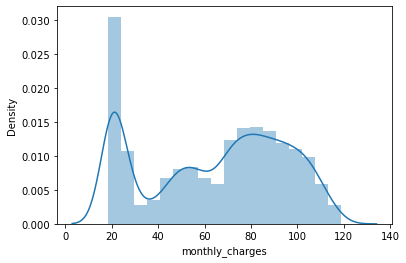

In [31]:
sns.distplot(df.monthly_charges)

<AxesSubplot:xlabel='tenure', ylabel='Density'>

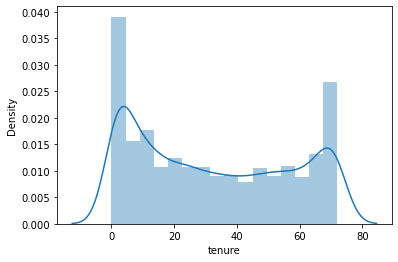

In [32]:
sns.distplot(df.tenure)

<AxesSubplot:xlabel='total_charges', ylabel='Density'>

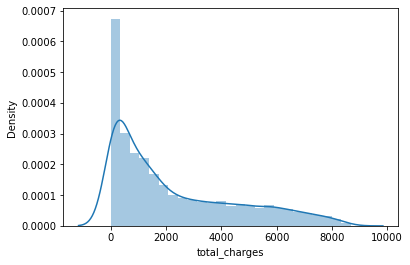

In [33]:
sns.distplot(df.total_charges)